In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [8]:
# --- Imports and Setup ---
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    TrainingArguments, Trainer
)
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load and Prepare Data ---
df_q = pd.read_csv("/content/drive/MyDrive/NLP_project_1/sentiment_question_output.csv")
df_q = df_q[['question', 'sentiment']].dropna()
df_q['sentiment'] = df_q['sentiment'].str.strip().str.lower()
df_q['label'] = df_q['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
df_q = df_q.dropna(subset=['label'])
df_q['label'] = df_q['label'].astype(int)

dataset_q = Dataset.from_pandas(df_q[['question', 'label']])

# --- Tokenize ---
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def tokenize_q(example):
    tokens = tokenizer(example['question'], truncation=True, padding='max_length', max_length=128)
    tokens["label"] = example["label"]
    return tokens

tokenized_q = dataset_q.map(tokenize_q).train_test_split(test_size=0.2)

Map:   0%|          | 0/10793 [00:00<?, ? examples/s]

In [ ]:


# --- Train Model ---
model_q = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)

training_args_q = TrainingArguments(
    output_dir="./results_question",
    do_train=True,
    do_eval=True,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs_question",
    logging_steps=100,
    save_steps=100,
    eval_steps=100,
    save_total_limit=2
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

trainer_q = Trainer(
    model=model_q,
    args=training_args_q,
    train_dataset=tokenized_q["train"],
    eval_dataset=tokenized_q["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_q.train()
trainer_q.save_model("distilbert-sentiment-question")


Map: 100%|██████████| 10793/10793 [00:01<00:00, 7500.46 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Jue\AppData\Local\Temp\ipykernel_27676\585639419.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_q = Trainer(


Step,Training Loss
100,0.554900
200,0.299400
300,0.223700
400,0.233500
500,0.214600
600,0.208600
700,0.168200
800,0.151700
900,0.142000
1000,0.172200


In [5]:
# --- Load and Prepare Data ---
df_r = pd.read_csv("/content/drive/MyDrive/NLP_project_1/sentiment_reading_output.csv")
df_r = df_r[['reading', 'sentiment']].dropna()
df_r['sentiment'] = df_r['sentiment'].str.strip().str.lower()
df_r['label'] = df_r['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
df_r = df_r.dropna(subset=['label'])
df_r['label'] = df_r['label'].astype(int)

dataset_r = Dataset.from_pandas(df_r[['reading', 'label']])

# --- Tokenize ---
def tokenize_r(example):
    tokens = tokenizer(example['reading'], truncation=True, padding='max_length', max_length=128)
    tokens["label"] = example["label"]
    return tokens

tokenized_r = dataset_r.map(tokenize_r).train_test_split(test_size=0.2)

Map:   0%|          | 0/12147 [00:00<?, ? examples/s]

In [ ]:


# --- Train Model ---
model_r = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)

training_args_r = TrainingArguments(
    output_dir="./results_reading",
    do_train=True,
    do_eval=True,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs_reading",
    logging_steps=100,
    save_steps=100,
    eval_steps=100,
    save_total_limit=2
)

trainer_r = Trainer(
    model=model_r,
    args=training_args_r,
    train_dataset=tokenized_r["train"],
    eval_dataset=tokenized_r["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_r.train()
trainer_r.save_model("distilbert-sentiment-reading")


Map: 100%|██████████| 12147/12147 [00:02<00:00, 4605.83 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Jue\AppData\Local\Temp\ipykernel_27676\1934214436.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_r = Trainer(


Step,Training Loss
100,0.639400
200,0.396900
300,0.391200
400,0.326600
500,0.320900
600,0.306500
700,0.222300
800,0.266300
900,0.217100
1000,0.233500


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import numpy as np

# Load model and tokenizer

model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP_project_1/distilbert-sentiment-question").to(device)
model1 = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP_project_1/distilbert-sentiment-reading").to(device)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")



In [9]:
# Prepare the test set
test_dataset = tokenized_q["test"]




In [10]:
test_dataset1 = tokenized_r["test"]




In [14]:
test_dataset

Dataset({
    features: ['question', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2159
})

In [13]:
test_dataset1

Dataset({
    features: ['reading', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2430
})

In [15]:
from torch.utils.data import DataLoader
import torch

# Define the collate_fn that converts a list of dictionaries into a dictionary of tensors
def collate_fn(batch):
    # Convert input fields to tensors (ensure correct data types)
    batch = {key: torch.tensor([d[key] for d in batch]).to(device) for key in batch[0] if key != 'question'}  # Don't include text fields
    return batch

# Create DataLoader using the updated collate_fn
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [16]:
from torch.utils.data import DataLoader
import torch

# Define the collate_fn that converts a list of dictionaries into a dictionary of tensors
def collate_fn(batch):
    # Convert input fields to tensors (ensure correct data types)
    batch = {key: torch.tensor([d[key] for d in batch]).to(device) for key in batch[0] if key != 'reading'}  # Don't include text fields
    return batch

# Create DataLoader using the updated collate_fn
test_loader1 = DataLoader(test_dataset1, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [17]:
# Model evaluation
model.eval()  # Ensure the model is in evaluation mode
predictions = []
true_labels = []

for batch in test_loader:
    # Prepare the inputs and move them to the correct device
    inputs = {key: batch[key].to(device) for key in batch if key != 'label'}
    labels = batch['label'].to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)  # Pass the inputs correctly
        preds = torch.argmax(outputs.logits, axis=-1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())


In [22]:
# Model evaluation
model1.eval()  # Ensure the model is in evaluation mode
predictions_r = []
true_labels_r = []

for batch1 in test_loader1:
    # Prepare the inputs and move them to the correct device
    inputs1 = {key: batch1[key].to(device) for key in batch1 if key != 'label'}
    labels1 = batch1['label'].to(device)

    # Make predictions
    with torch.no_grad():
        outputs1 = model1(**inputs1)  # Pass the inputs correctly
        preds1 = torch.argmax(outputs1.logits, axis=-1)

    predictions_r.extend(preds1.cpu().numpy())
    true_labels_r.extend(labels1.cpu().numpy())


In [19]:
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

print("For question sentiment:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


For question sentiment:
Accuracy: 0.9713
F1-Score: 0.9715


In [23]:
accuracy_r = accuracy_score(true_labels_r, predictions_r)
f1_r = f1_score(true_labels_r, predictions_r, average='weighted')

print("For reading sentiment:")
print(f"Accuracy: {accuracy_r:.4f}")
print(f"F1-Score: {f1_r:.4f}")


For reading sentiment:
Accuracy: 0.9741
F1-Score: 0.9740


Question Sentiment model's confusion matrix:


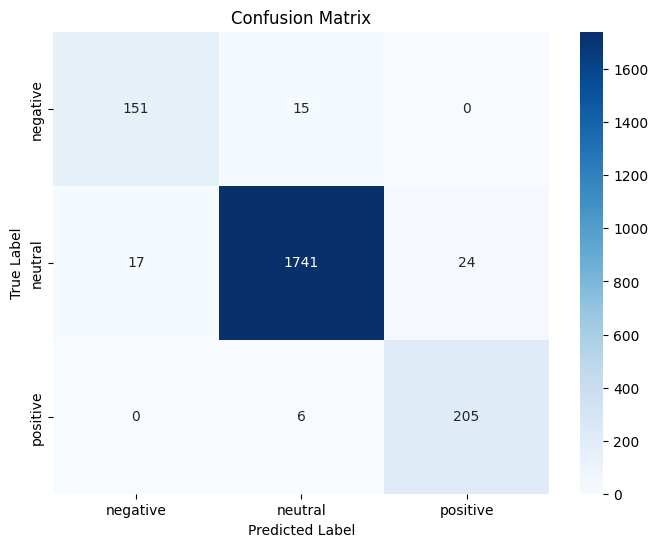

In [24]:
import matplotlib.pyplot as plt
# Compute confusion matrix
print("Question Sentiment model's confusion matrix:")
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


Reading Sentiment model's confusion matrix:


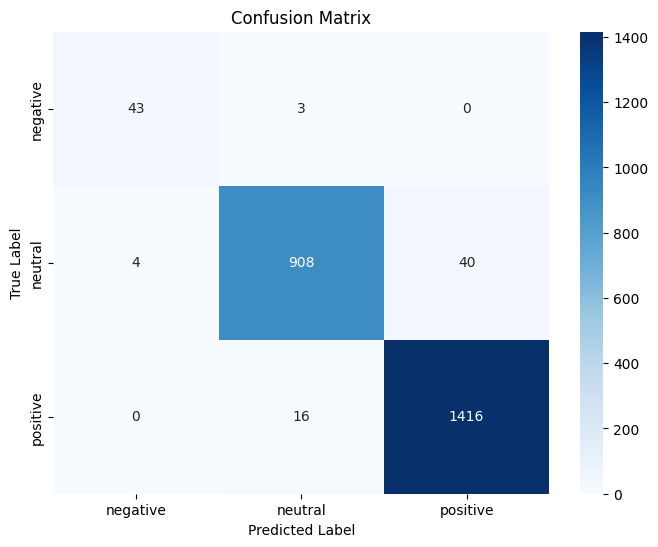

In [25]:
import matplotlib.pyplot as plt
# Compute confusion matrix
print("Reading Sentiment model's confusion matrix:")
cm_r = confusion_matrix(true_labels_r, predictions_r)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [21]:
report = classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive'])
print("For question sentiment:")
print(report)


For question sentiment:
              precision    recall  f1-score   support

    negative       0.90      0.91      0.90       166
     neutral       0.99      0.98      0.98      1782
    positive       0.90      0.97      0.93       211

    accuracy                           0.97      2159
   macro avg       0.93      0.95      0.94      2159
weighted avg       0.97      0.97      0.97      2159



In [26]:
report_r = classification_report(true_labels_r, predictions_r, target_names=['negative', 'neutral', 'positive'])
print("For reading sentiment:")
print(report_r)


For reading sentiment:
              precision    recall  f1-score   support

    negative       0.91      0.93      0.92        46
     neutral       0.98      0.95      0.97       952
    positive       0.97      0.99      0.98      1432

    accuracy                           0.97      2430
   macro avg       0.96      0.96      0.96      2430
weighted avg       0.97      0.97      0.97      2430



In [27]:
# Save predictions
predictions_df = pd.DataFrame({
    'Question': test_dataset['question'],
    'True Label': true_labels,
    'Predicted Label': predictions
})

predictions_df.head(20)


,Question,True Label,Predicted Label
0,What is my purpose right now?,1,1
1,What fears am I facing right now?,1,1
2,What is my role in the bigger picture?,1,1
3,How can I embrace my authentic power?,1,1
4,What am I learning from my relationships?,1,1
5,What fear do I need to release?,1,1
6,What is the shadow self I need to acknowledge?,1,1
7,How can I improve my communication skills?,1,1
8,What is the importance of setting goals?,1,1
9,What do I need to focus on for personal develo...,1,1


In [29]:
# Save predictions
predictions_df_r = pd.DataFrame({
    'Reading': test_dataset1['reading'],
    'True Label': true_labels_r,
    'Predicted Label': predictions_r
})

predictions_df_r.head(20)


,Reading,True Label,Predicted Label
0,"Aquarius, you're juggling a lot right now, and...",1,1
1,This Five of Cups shows you're stuck focusing ...,1,1
2,"Aries, this situation feels like a painful end...",2,2
3,With the Two of Swords suggesting some avoidan...,1,1
4,"Virgo, with Strength, the Seven of Pentacles, ...",2,2
5,"The Chariot and Knight of Pentacles, combined ...",1,1
6,"You're feeling burdened, Pisces, like you're c...",1,1
7,The Hermit suggests you need some alone time t...,2,2
8,"For an Aquarius, this Queen of Pentacles shows...",2,2
9,"Capricorn, you're shouldering a heavy load rig...",2,2


In [30]:
predictions_df.to_csv('/content/drive/MyDrive/NLP_project_1/Question_predictions.csv', index=False)
predictions_df_r.to_csv('/content/drive/MyDrive/NLP_project_1/Reading_predictions.csv', index=False)